# Pylops - Seismic Inversion with cupy

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.backend              import get_lstsq
from pylops.utils.wavelets             import *
from pylops.basicoperators             import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.basic         import *
from pylops.optimization.leastsquares  import *
dtype = np.float32

## 1D Prestack modelling and inversion

<class 'cupy._core.core.ndarray'> <class 'cupy._core.core.ndarray'> float64 float64


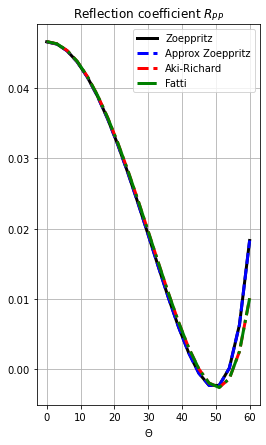

In [2]:
vp1, vs1, rho1 = 2200., 1300., 2000  # upper medium
vp0, vs0, rho0 = 2300., 1400., 2100  # lower medium

ntheta = 21
thetamin, thetamax = 0, 60
theta = cp.linspace(thetamin, thetamax, ntheta)

# Create composite parameters
ai0, si0, vpvs0 = vp0*rho0, vs0*rho0, vp0/vs0
ai1, si1, vpvs1 = vp1*rho1, vs1*rho1, vp1/vs1

# Zoeppritz
rpp_zoep = zoeppritz_pp(vp1, vs1, rho1, vp0, vs0, rho0, theta)
rpp_zoep_approx = approx_zoeppritz_pp(vp1, vs1, rho1, vp0, vs0, rho0, theta)
print(type(rpp_zoep), type(rpp_zoep_approx), rpp_zoep.dtype, rpp_zoep_approx.dtype)

# Aki Richards
rvp = np.log(vp0) - np.log(vp1)
rvs = np.log(vs0) - np.log(vs1)
rrho = np.log(rho0) - np.log(rho1)

G1, G2, G3 = akirichards(theta, vs1/vp1)
rpp_aki = G1*rvp + G2*rvs + G3*rrho

# Fatti
rai = np.log(ai0) - np.log(ai1)
rsi = np.log(si0) - np.log(si1)

G1, G2, G3 = fatti(theta, vs1/vp1)
rpp_fatti = G1*rai + G2*rsi + G3*rrho

plt.figure(figsize=(4,7))
plt.plot(cp.asnumpy(theta), cp.asnumpy(rpp_zoep), 'k', lw=3, label='Zoeppritz')
plt.plot(cp.asnumpy(theta), cp.asnumpy(rpp_zoep_approx), '--b', lw=3, label='Approx Zoeppritz')
plt.plot(cp.asnumpy(theta), cp.asnumpy(rpp_aki), '--r', lw=3, label='Aki-Richard')
plt.plot(cp.asnumpy(theta), cp.asnumpy(rpp_fatti), '-.g', lw=3, label='Fatti')
plt.xlabel(r'$\Theta$')
plt.title(r'Reflection coefficient $R_{PP}$')
plt.grid()
plt.legend();

float32 float32 float32


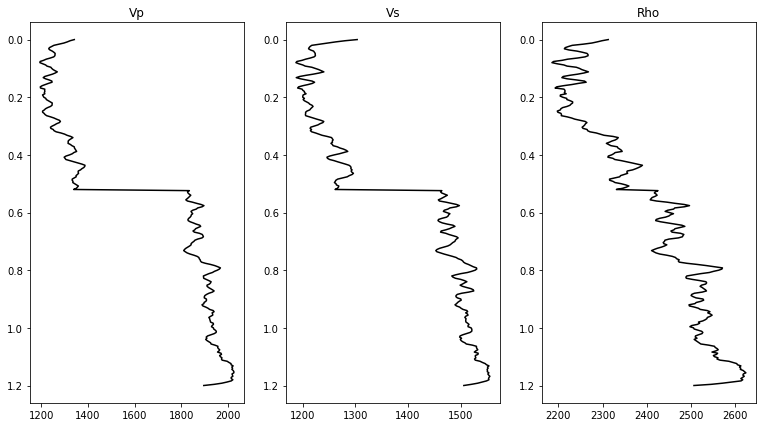

In [3]:
np.random.seed(0)

nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 80, nt0))
vs  = 600  + vp/2           + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 20, nt0))
rho = 1000 + vp             + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 30, nt0))
vp[131:]+=500
vs[131:]+=200
rho[131:]+=100

fig, axs = plt.subplots (1, 3, figsize=(13,7))
axs[0].plot(vp,  t0, 'k')
axs[0].set_title('Vp')
axs[0].invert_yaxis()
axs[1].plot(vs,  t0, 'k')
axs[1].set_title('Vs')
axs[1].invert_yaxis()
axs[2].plot(rho, t0, 'k')
axs[2].set_title('Rho')
axs[2].invert_yaxis()

vp, vs, rho = cp.asarray(vp).astype(dtype), cp.asarray(vs).astype(dtype), cp.asarray(rho).astype(dtype)
print(vp.dtype, vs.dtype, rho.dtype)

In [4]:
ntheta = 21
thetamin, thetamax = 0, 40
theta = np.linspace(thetamin, thetamax, ntheta)

ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

vsvp   = 0.5
vsvp_z = np.linspace(0.4, 0.6, nt0)

m = np.stack((np.log(vp), np.log(vs), np.log(rho)),axis=1)
m = cp.asarray(m).astype(dtype)

In [5]:
# lop (constant vsvp)
PPop = PrestackLinearModelling(cp.asarray(wav).astype(dtype), cp.asarray(theta).astype(dtype), vsvp=vsvp, 
                               nt0=nt0, linearization='akirich')
dottest(PPop, nt0*ntheta, nt0*3, verb=True, atol=1e-3, backend='cupy')

# dense (constant vsvp)
PPop_dense = PrestackLinearModelling(cp.asarray(wav).astype(dtype), cp.asarray(theta).astype(dtype), vsvp=vsvp, 
                                     nt0=nt0, linearization='akirich', explicit=True)
dottest(PPop_dense, nt0*ntheta, nt0*3, verb=True, atol=1e-3, backend='cupy')
print(PPop, PPop_dense)

# lop (depth-variant vsvp)
PPop = PrestackLinearModelling(cp.asarray(wav).astype(dtype), cp.asarray(theta).astype(dtype), 
                               vsvp=cp.asarray(vsvp_z).astype(dtype), linearization='akirich')
dottest(PPop, nt0*ntheta, nt0*3, verb=True, atol=1e-3, backend='cupy')

# dense (depth-variant vsvp)
PPop_dense = PrestackLinearModelling(cp.asarray(wav).astype(dtype), cp.asarray(theta).astype(dtype), 
                               vsvp=cp.asarray(vsvp_z).astype(dtype), linearization='akirich', explicit=True)
dottest(PPop_dense, nt0*ntheta, nt0*3, verb=True, atol=1e-3, backend='cupy')
print(PPop, PPop_dense)

Dot test passed, v^H(Opu)=62.79168701171875 - u^H(Op^Hv)=62.79167556762695
Dot test passed, v^H(Opu)=33.86896896362305 - u^H(Op^Hv)=33.86896514892578
<6321x903 LinearOperator with dtype=float32> <6321x903 MatrixMult with dtype=float32>
Dot test passed, v^H(Opu)=40.69961166381836 - u^H(Op^Hv)=40.69961166381836
Dot test passed, v^H(Opu)=34.496543884277344 - u^H(Op^Hv)=34.496543884277344
<6321x903 LinearOperator with dtype=float32> <6321x903 MatrixMult with dtype=float32>


In [6]:
# lop
dPP = PPop * m.flatten()
dPP = dPP.reshape(nt0,ntheta)

# dense
dPP_dense = PPop_dense * m.T.flatten()
dPP_dense = dPP_dense.reshape(ntheta,nt0).T
dPPn_dense = dPP_dense + cp.random.normal(0, 1e-2, dPP_dense.shape).astype(dtype)

print(dPP.dtype, dPP_dense.dtype)

float32 float32


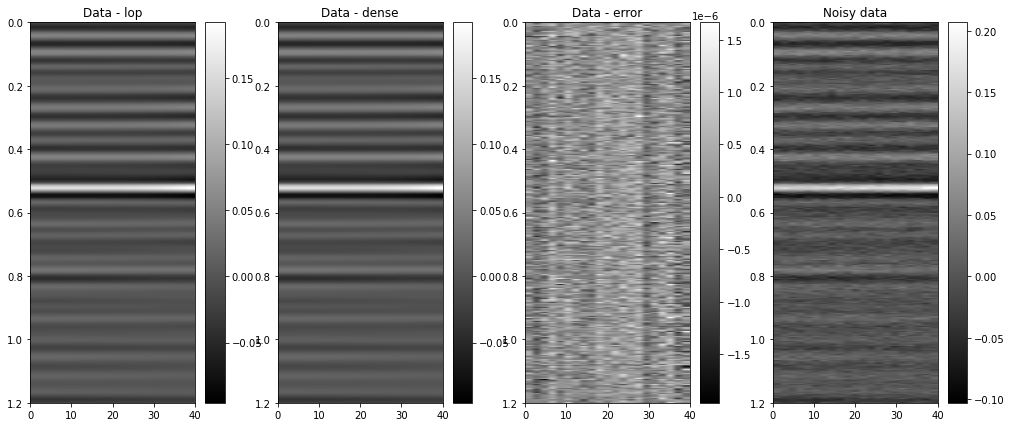

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(17,7))
im = axs[0].imshow(cp.asnumpy(dPP), cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]))
axs[0].set_title('Data - lop');
axs[0].axis('tight');
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(cp.asnumpy(dPP_dense), cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]))
axs[1].set_title('Data - dense');
axs[1].axis('tight');
fig.colorbar(im, ax=axs[1])
im = axs[2].imshow(cp.asnumpy(dPP - dPP_dense), cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]))
axs[2].set_title('Data - error');
axs[2].axis('tight');
fig.colorbar(im, ax=axs[2]);
im = axs[3].imshow(cp.asnumpy(dPPn_dense), cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]))
axs[3].set_title('Noisy data');
axs[3].axis('tight');
fig.colorbar(im, ax=axs[3]);

In [8]:
nsmooth = 50
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, cp.asnumpy(m), axis=0)
mback = cp.asarray(mback).astype(np.float32)

# lop
dPP_0 = PPop * mback.ravel()
dPP_r = dPP.ravel() - dPP_0

minv = normal_equations_inversion(PPop, dPP_r, None, epsI=0, **dict(engine='pylops', niter=100))[0]
minv = minv.reshape(nt0,3)

# dense
dPP_0_dense = PPop_dense*mback.T.ravel()
dPP_r_dense = dPP_dense.T.ravel() - dPP_0_dense 

minv_dense = cp.linalg.lstsq(PPop_dense.A, dPP_r_dense, rcond=1e-5)[0]
minv_dense = minv_dense.reshape(3, nt0).T

minv = mback+minv
minv_dense = mback+minv_dense

print(m.dtype, mback.dtype, minv.dtype, minv_dense.dtype)

float32 float32 float32 float32


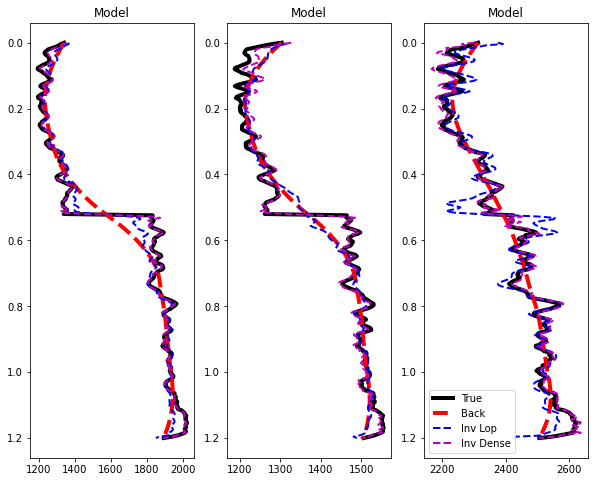

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].plot(cp.asnumpy(vp), t0, 'k', lw=4, label='True')
axs[0].plot(np.exp(cp.asnumpy(mback)[:, 0]), t0, '--r', lw=4, label='Back')
axs[0].plot(np.exp(cp.asnumpy(minv)[:, 0]), t0, '--b', lw=2, label='Inv Lop')
axs[0].plot(np.exp(cp.asnumpy(minv_dense)[:, 0]), t0, '--m', lw=2, label='Inv Dense')
axs[0].set_title('Model')
axs[0].invert_yaxis()
axs[1].plot(cp.asnumpy(vs), t0, 'k', lw=4, label='True')
axs[1].plot(np.exp(cp.asnumpy(mback)[:, 1]), t0, '--r', lw=4, label='Back')
axs[1].plot(np.exp(cp.asnumpy(minv)[:, 1]), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(np.exp(cp.asnumpy(minv_dense)[:, 1]), t0, '--m', lw=2, label='Inv Dense')
#axs[1].plot(np.exp(minv_noise[:, 1]), t0, '--g', lw=2, label='Inv Noisy')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[2].plot(cp.asnumpy(rho), t0, 'k', lw=4, label='True')
axs[2].plot(np.exp(cp.asnumpy(mback)[:, 2]), t0, '--r', lw=4, label='Back')
axs[2].plot(np.exp(cp.asnumpy(minv)[:, 2]), t0, '--b', lw=2, label='Inv Lop')
axs[2].plot(np.exp(cp.asnumpy(minv_dense)[:, 2]), t0, '--m', lw=2, label='Inv Dense')
#axs[2].plot(np.exp(minv_noise[:, 2]), t0, '--g', lw=2, label='Inv Noisy')
axs[2].set_title('Model')
axs[2].invert_yaxis()
axs[2].axis('tight')
axs[2].legend();

float32 float32 float32 float32


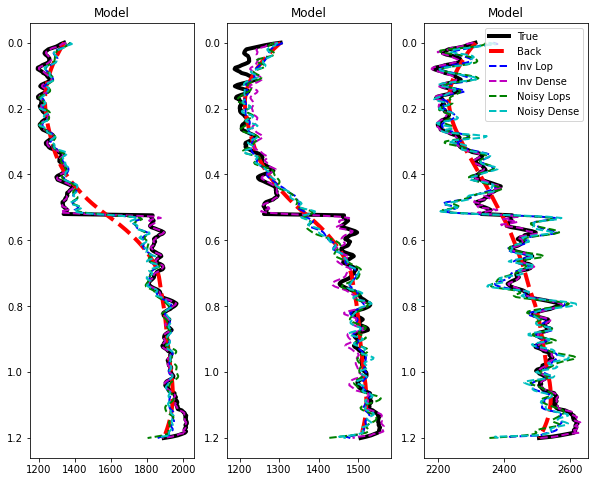

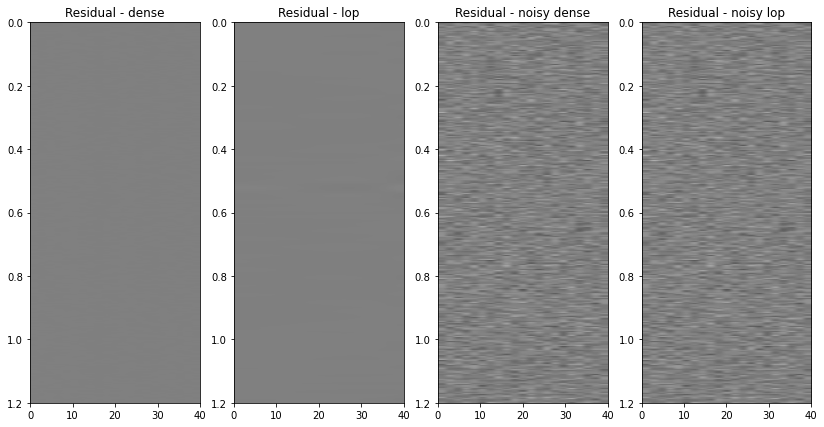

In [10]:
minv_dense, dPP_dense_res = \
    PrestackInversion(dPP_dense, cp.asarray(theta).astype(dtype), cp.asarray(wav).astype(dtype), 
                      m0=mback, linearization='akirich',
                      explicit=True, returnres=True, **dict(rcond=1e-5))

minv, dPP_res = \
    PrestackInversion(dPP, cp.asarray(theta).astype(dtype), cp.asarray(wav).astype(dtype), 
                      m0=mback, linearization='akirich',
                      explicit=False, returnres=True, **dict(damp=1e-10, niter=2000))

minv_dense_noise, dPPn_dense_res = \
    PrestackInversion(dPPn_dense, cp.asarray(theta).astype(dtype), cp.asarray(wav).astype(dtype), m0=mback, 
                      linearization='akirich', explicit=True, 
                      simultaneous=False, returnres=True, **dict(rcond=2e-2))

minv_noise, dPPn_res = \
    PrestackInversion(dPPn_dense, cp.asarray(theta).astype(dtype), cp.asarray(wav).astype(dtype), m0=mback, 
                      linearization='akirich', explicit=False, 
                      epsR=5e-1, returnres=True, **dict(engine='pylops', damp=1e-1, niter=2000))

print(minv_dense.dtype, minv.dtype, minv_dense_noise.dtype, minv_noise.dtype)

fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].plot(cp.asnumpy(vp), t0, 'k', lw=4, label='True')
axs[0].plot(np.exp(cp.asnumpy(mback)[:, 0]), t0, '--r', lw=4, label='Back')
axs[0].plot(np.exp(cp.asnumpy(minv)[:, 0]), t0, '--b', lw=2, label='Inv Lop')
axs[0].plot(np.exp(cp.asnumpy(minv_dense)[:, 0]), t0, '--m', lw=2, label='Inv Dense')
axs[0].plot(np.exp(cp.asnumpy(minv_noise)[:, 0]), t0, '--g', lw=2, label='Noisy Lops')
axs[0].plot(np.exp(cp.asnumpy(minv_dense_noise)[:, 0]), t0, '--c', lw=2, label='Noisy Dense')
axs[0].set_title('Model')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[1].plot(cp.asnumpy(vs), t0, 'k', lw=4, label='True')
axs[1].plot(np.exp(cp.asnumpy(mback)[:, 1]), t0, '--r', lw=4, label='Back')
axs[1].plot(np.exp(cp.asnumpy(minv)[:, 1]), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(np.exp(cp.asnumpy(minv_dense)[:, 1]), t0, '--m', lw=2, label='Inv Dense')
axs[1].plot(np.exp(cp.asnumpy(minv_noise)[:, 1]), t0, '--g', lw=2, label='Noisy Lops')
axs[1].plot(np.exp(cp.asnumpy(minv_dense_noise)[:, 1]), t0, '--c', lw=2, label='Noisy Dense')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[2].plot(cp.asnumpy(rho), t0, 'k', lw=4, label='True')
axs[2].plot(np.exp(cp.asnumpy(mback)[:, 2]), t0, '--r', lw=4, label='Back')
axs[2].plot(np.exp(cp.asnumpy(minv)[:, 2]), t0, '--b', lw=2, label='Inv Lop')
axs[2].plot(np.exp(cp.asnumpy(minv_dense)[:, 2]), t0, '--m', lw=2, label='Inv Dense')
axs[2].plot(np.exp(cp.asnumpy(minv_noise)[:, 2]), t0, '--g', lw=2, label='Noisy Lops')
axs[2].plot(np.exp(cp.asnumpy(minv_dense_noise)[:, 2]), t0, '--c', lw=2, label='Noisy Dense')
axs[2].set_title('Model')
axs[2].invert_yaxis()
axs[2].axis('tight')
axs[2].legend();

fig, axs = plt.subplots(1, 4, figsize=(14,7))
im = axs[0].imshow(cp.asnumpy(dPP_dense_res), cmap='gray', 
                   extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[0].set_title('Residual - dense');
axs[0].axis('tight');
im = axs[1].imshow(cp.asnumpy(dPP_res), cmap='gray', 
                   extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[1].set_title('Residual - lop');
axs[1].axis('tight');
im = axs[2].imshow(cp.asnumpy(dPPn_dense_res), cmap='gray', 
                   extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[2].set_title('Residual - noisy dense');
axs[2].axis('tight');
im = axs[3].imshow(cp.asnumpy(dPPn_res), cmap='gray', 
                   extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[3].set_title('Residual - noisy lop');
axs[3].axis('tight');

## Wavelet estimation

<6321x41 VStack with dtype=float32> <6321x41 VStack with dtype=float32>
Dot test passed, v^H(Opu)=2.2436482906341553 - u^H(Op^Hv)=2.2436485290527344
Dot test passed, v^H(Opu)=-9.921501159667969 - u^H(Op^Hv)=-9.921501159667969
float32 float32


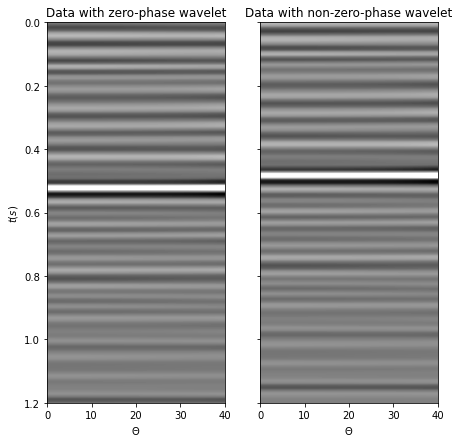

In [11]:
# Create wavelets
ntwav = 41
wavoff=10
wav, twav, wavc = ricker(t0[:ntwav//2+1],20)
wav_phase = np.hstack((wav[wavoff:], np.zeros(wavoff)))

# Create operators
Wavesop = PrestackWaveletModelling(m.astype(np.float32), cp.asarray(theta).astype(np.float32), nwav=ntwav, wavc=wavc,
                                   vsvp=vsvp, linearization='akirich')
Wavesop_phase = PrestackWaveletModelling(m.astype(np.float32), cp.asarray(theta).astype(np.float32), nwav=ntwav, wavc=wavc,
                                         vsvp=vsvp, linearization='akirich')
print(Wavesop, Wavesop_phase)
dottest(Wavesop, nt0*ntheta, ntwav, verb=True, backend='cupy')
dottest(Wavesop_phase, nt0*ntheta, ntwav, verb=True, backend='cupy')

# Create data
d = (Wavesop*cp.asarray(wav)).reshape(ntheta,nt0).T
d_phase = (Wavesop_phase*cp.asarray(wav_phase)).reshape(ntheta,nt0).T
print(d.dtype, d_phase.dtype)

fig, axs = plt.subplots(1,2, figsize=(7,7), sharey=True)
axs[0].imshow(cp.asnumpy(d), cmap='gray', extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[0].axis('tight')
axs[0].set_xlabel(r'$\Theta$'), axs[0].set_ylabel(r'$t(s)$')
axs[0].set_title('Data with zero-phase wavelet')
axs[1].imshow(cp.asnumpy(d_phase), cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[1].axis('tight')
axs[1].set_title('Data with non-zero-phase wavelet')
axs[1].set_xlabel(r'$\Theta$');

float32 float32


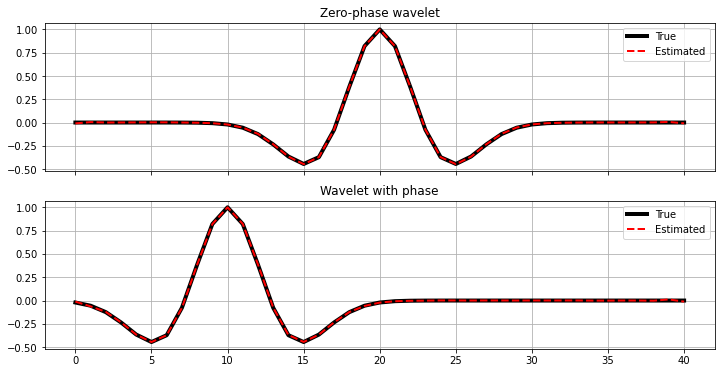

In [12]:
wav_est = Wavesop / d.T.flatten()
wav_phase_est = Wavesop_phase / d_phase.T.flatten()
print(wav_est.dtype, wav_phase_est.dtype)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,6))
axs[0].plot(wav, 'k', lw=4, label='True')
axs[0].plot(cp.asnumpy(wav_est), '--r', lw=2, label='Estimated')
axs[0].set_title('Zero-phase wavelet')
axs[0].grid()
axs[0].legend(loc='best')
axs[0].axis('tight')
axs[1].plot(wav_phase, 'k', lw=4, label='True')
axs[1].plot(cp.asnumpy(wav_phase_est), '--r', lw=2, label='Estimated')
axs[1].set_title('Wavelet with phase')
axs[1].grid()
axs[1].legend(loc='best')
axs[1].axis('tight');

float32 float32


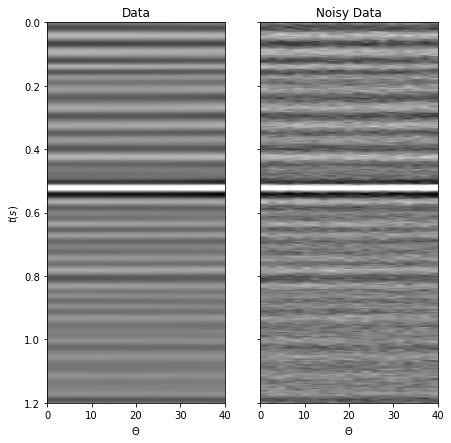

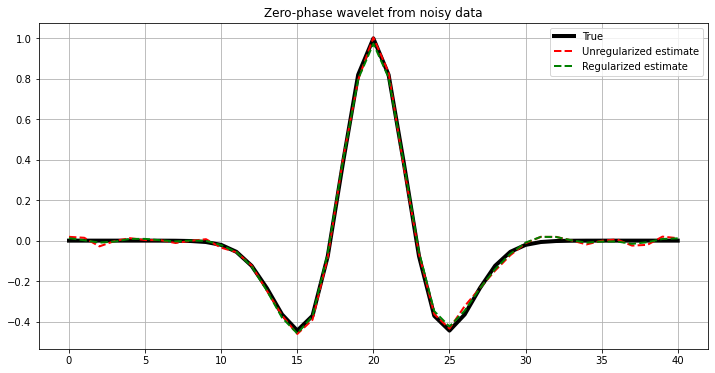

In [13]:
#add noise 
dn = d + cp.random.normal(0, 1e-2, d.shape).astype(dtype)

# unregularized estimate
wavn_est = Wavesop / dn.T.flatten()

# regularized estimate
# Create regularization operator
D2op  = SecondDerivative(ntwav, dtype=dtype)

# Invert for interpolated signal
wavn_reg_est, istop, itn, r1norm, r2norm = \
    regularized_inversion(Wavesop, dn.T.flatten(), [D2op], epsRs=[np.sqrt(0.1)],
                         **dict(engine='pylops', damp=np.sqrt(1e-4), niter=200 ,show=0))
print(wavn_est.dtype, wavn_reg_est.dtype)

fig, axs = plt.subplots(1,2, figsize=(7,7), sharey=True)
axs[0].imshow(cp.asnumpy(d), cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[0].axis('tight')
axs[0].set_xlabel(r'$\Theta$'), axs[0].set_ylabel(r'$t(s)$')
axs[0].set_title('Data')
axs[1].imshow(cp.asnumpy(dn), cmap='gray', 
              extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1)
axs[1].axis('tight')
axs[1].set_title('Noisy Data')
axs[1].set_xlabel(r'$\Theta$');

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))
ax.plot(wav, 'k', lw=4, label='True')
ax.plot(cp.asnumpy(wavn_est), '--r', lw=2, label='Unregularized estimate')
ax.plot(cp.asnumpy(wavn_reg_est), '--g', lw=2, label='Regularized estimate')
ax.set_title('Zero-phase wavelet from noisy data')
ax.grid()
ax.legend(loc='best')
ax.axis('tight');

float32 float32


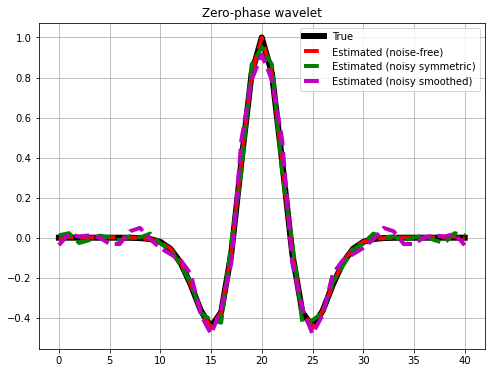

In [14]:
# Create symmetrize operator
Sop = Symmetrize((ntwav+1)//2, dtype=dtype)

# Create smoothing operator
Smop = Smoothing1D(5, dims=((ntwav+1)//2,), dtype=dtype)

# Invert for interpolated signal
wavn_prec_est = \
    preconditioned_inversion(Wavesop, dn.T.flatten(), Sop, 
                             **dict(engine='pylops', 
                                    damp=np.sqrt(1e-4),
                                    niter=200, show=0))[0]

wavn_smooth_est = \
    preconditioned_inversion(Wavesop, dn.T.flatten(), Sop*Smop,
                             **dict(engine='pylops', 
                                    damp=np.sqrt(1e-4),
                                    niter=200, show=0))[0]

print(wavn_prec_est.dtype, wavn_smooth_est.dtype)


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))
ax.plot(wav, 'k', lw=6, label='True')
ax.plot(cp.asnumpy(wav_est), '--r', lw=4, label='Estimated (noise-free)')
ax.plot(cp.asnumpy(wavn_prec_est), '--g', lw=4, label='Estimated (noisy symmetric)')
ax.plot(cp.asnumpy(wavn_smooth_est), '--m', lw=4, label='Estimated (noisy smoothed)')
ax.set_title('Zero-phase wavelet')
ax.grid()
ax.legend(loc='upper right');

## 1D Poststack inversion

In [15]:
m1d = cp.asarray(np.log(vp*rho).flatten()).astype(dtype)

# lop
PPop = PoststackLinearModelling(cp.asarray(wav).astype(dtype), nt0=nt0, explicit=False)
dottest(PPop, nt0, nt0, verb=True, atol=1e-4, backend='cupy')

# dense
PPop_dense = PoststackLinearModelling(cp.asarray(wav).astype(dtype), nt0=nt0, explicit=True)
dottest(PPop_dense, nt0, nt0, verb=True, atol=1e-4, backend='cupy')

print(PPop, PPop_dense, PPop_dense.A.dtype)

# data
d = PPop * m1d
d_dense = PPop_dense * m1d.flatten()
dn_dense = d_dense + cp.random.normal(0, 3e-2, d_dense.shape).astype(np.float32)
print(d.dtype, d_dense.dtype)

Dot test passed, v^H(Opu)=2.0727920532226562 - u^H(Op^Hv)=2.072793960571289
Dot test passed, v^H(Opu)=15.545571327209473 - u^H(Op^Hv)=15.54556655883789
<301x301 LinearOperator with dtype=float32> <301x301 MatrixMult with dtype=float32> float32
float32 float32


float32 float32 float32 float32


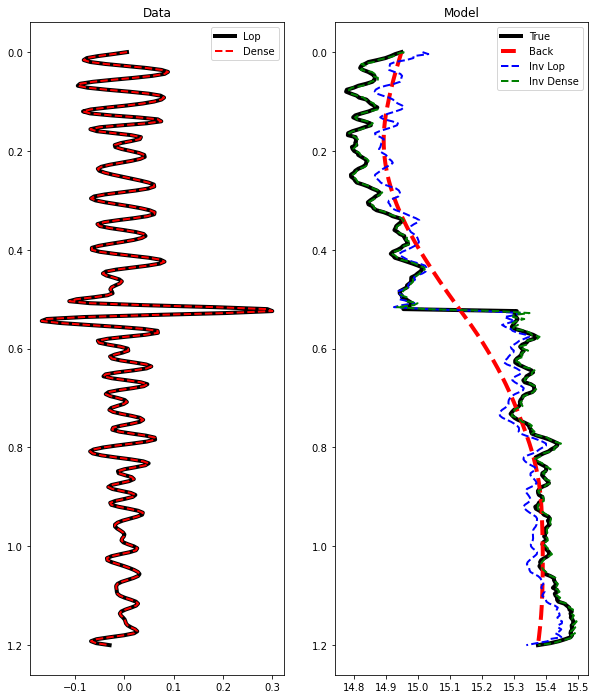

In [16]:
nsmooth = 100
m1dback = cp.asarray(filtfilt(np.ones(nsmooth).astype(dtype)/float(nsmooth), 1, cp.asnumpy(m1d))).astype(dtype)

# solve lop
d0 = PPop*m1dback
dr = d - d0
minv = cgls(PPop, dr, cp.zeros_like(m1dback).astype(dtype), niter=600, tol=0)[0]
minv = m1dback + minv

# solve dense
d0_dense = PPop*m1dback
dr_dense = d_dense - d0_dense
minv_dense = cp.linalg.lstsq(PPop_dense.A, dr_dense, rcond=1e-5)[0]
minv_dense = m1dback + minv_dense

print(dr.dtype, dr_dense.dtype, minv.dtype, minv_dense.dtype)

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(cp.asnumpy(d), t0, 'k', lw=4, label='Lop')
axs[0].plot(cp.asnumpy(d_dense), t0,'--r', lw=2, label='Dense')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(cp.asnumpy(m1d), t0, 'k', lw=4, label='True')
axs[1].plot(cp.asnumpy(m1dback), t0, '--r', lw=4, label='Back')
axs[1].plot(cp.asnumpy(minv), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(cp.asnumpy(minv_dense), t0, '--g', lw=2, label='Inv Dense')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

float32 float32 float32


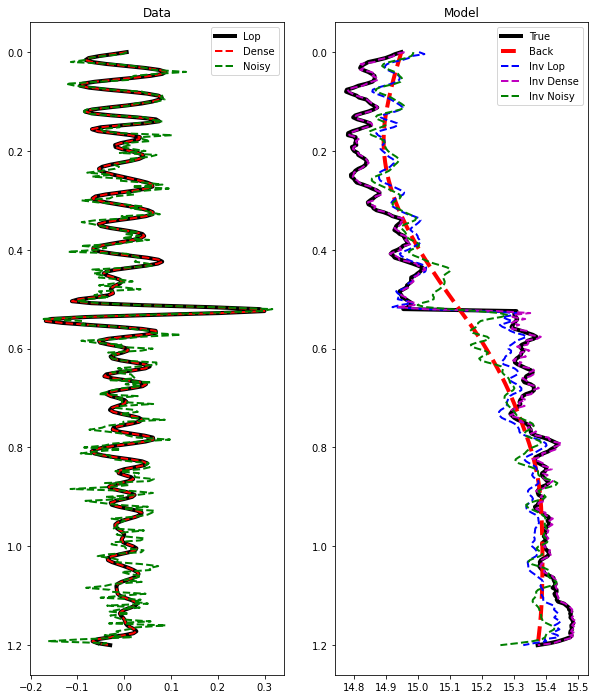

In [17]:
minv_dense = PoststackInversion(d_dense, cp.asarray(wav).astype(dtype), m0=m1dback, 
                                explicit=True, simultaneous=False, **dict(rcond=1e-5))[0]

minv = PoststackInversion(d_dense, cp.asarray(wav).astype(dtype), m0=m1dback.astype(dtype), 
                          explicit=False, simultaneous=False, **dict(niter=500, tol=0))[0]

minv_noise = PoststackInversion(dn_dense, cp.asarray(wav).astype(dtype), m0=m1dback.astype(dtype), explicit=True, 
                                epsR=1e0, **dict(engine='pylops', damp=1e-1))[0]

print(minv_dense.dtype, minv.dtype, minv_noise.dtype)

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(cp.asnumpy(d), t0, 'k', lw=4, label='Lop')
axs[0].plot(cp.asnumpy(d_dense), t0,'--r', lw=2, label='Dense')
axs[0].plot(cp.asnumpy(dn_dense), t0,'--g', lw=2, label='Noisy')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(cp.asnumpy(m1d), t0, 'k', lw=4, label='True')
axs[1].plot(cp.asnumpy(m1dback), t0, '--r', lw=4, label='Back')
axs[1].plot(cp.asnumpy(minv), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(cp.asnumpy(minv_dense), t0, '--m', lw=2, label='Inv Dense')
axs[1].plot(cp.asnumpy(minv_noise), t0, '--g', lw=2, label='Inv Noisy')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

## 2D Poststack inversion

In [18]:
inputfile = '../data/avo/poststack_model.npz'
model = np.load(inputfile)
x, z, m = model['x'], model['z'], cp.asarray(np.log(model['model'])).astype(dtype)
nx, nz = len(x), len(z)

In [19]:
# lop
PPop = PoststackLinearModelling(cp.asarray(wav).astype(dtype), nt0=nz, spatdims=nx, explicit=False)
dottest(PPop, nz*nx, nz*nx, verb=True, atol=1e-3, backend='cupy')

# dense
PPop_dense = PoststackLinearModelling(cp.asarray(wav).astype(dtype), nt0=nz, spatdims=nx, explicit=True)
dottest(PPop_dense, nz*nx, nz*nx, verb=True, atol=1e-3, backend='cupy')

# data
d = (PPop*m.ravel()).reshape(nz,nx)
d_dense = (PPop_dense*m.flatten()).reshape(nz,nx)
print((d - d_dense).max())

n = cp.random.normal(0, 1e-1, d_dense.shape).astype(dtype)
dn = d + n
dn_dense = d_dense + n

print(d.dtype, d_dense.dtype)

Dot test passed, v^H(Opu)=-104.03239440917969 - u^H(Op^Hv)=-104.03238677978516
Dot test passed, v^H(Opu)=-606.3642578125 - u^H(Op^Hv)=-606.3640747070312
5.9604645e-07
float32 float32


In [20]:
nsmooth = 60
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, cp.asnumpy(m), axis=0)
mback = cp.asarray(filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)).astype(dtype)

d_0_dense = PPop_dense*mback.ravel()
d_0_lop = PPop*mback.ravel()

In [21]:
madj_dense = PPop_dense.H*d_dense.ravel()
madj = PPop.H*d.ravel()
print((madj - madj_dense).max())

1.66893e-06


<440000x440000 LinearOperator with dtype=float32>
float32 float32 float32


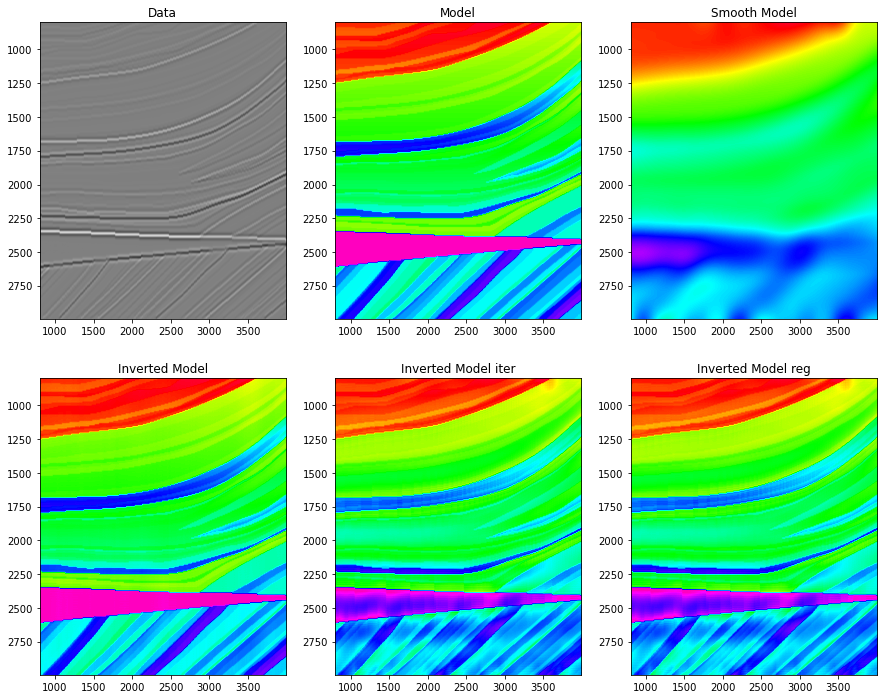

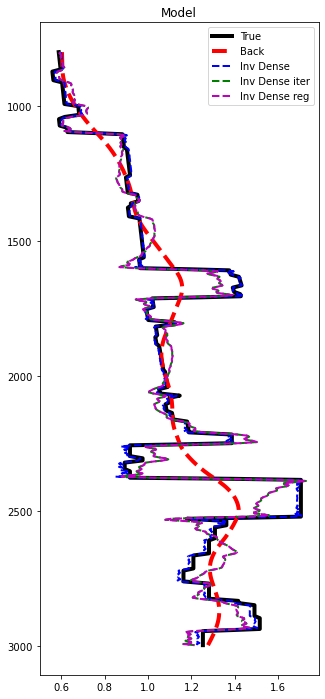

In [22]:
# solve all rows indipendently
d_r_dense = d_dense - d_0_dense.reshape(nz,nx)
minv_dense = get_lstsq(m)(PPop_dense.A, d_r_dense, rcond=1e-5)[0]
minv_dense = mback + minv_dense

# solve all rows together
d_r_dense_iter = d_dense - d_0_dense.reshape(nz,nx)
minv_dense_iter = cgls(PPop_dense, d_r_dense_iter.ravel(), cp.zeros_like(d_r_dense_iter.ravel()), niter=100)[0]
minv_dense_iter = minv_dense_iter.reshape(nz, nx)
minv_dense_iter = mback + minv_dense_iter.reshape(nz, nx)

# solve all rows together with regularization
D2op  = Laplacian([nz, nx], dtype=dtype)
print(D2op)

minv_dense_reg = normal_equations_inversion(PPop_dense, d_r_dense.flatten(), [D2op], 
                                            epsRs=[np.sqrt(1e-4)],
                                            **dict(engine='pylops', niter=100))[0]
minv_dense_reg = mback + minv_dense_reg.reshape(nz, nx)

print(minv_dense.dtype, minv_dense_iter.dtype, minv_dense_reg.dtype)

fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(cp.asnumpy(d), cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(cp.asnumpy(m), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(cp.asnumpy(mback), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(cp.asnumpy(minv_dense), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(cp.asnumpy(minv_dense_iter), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model iter')
axs[1][1].axis('tight');
axs[1][2].imshow(cp.asnumpy(minv_dense_reg), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model reg')
axs[1][2].axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(cp.asnumpy(m)[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(cp.asnumpy(mback)[:,nx//2], z, '--r', lw=4, label='Back')
ax.plot(cp.asnumpy(minv_dense)[:,nx//2], z, '--b', lw=2, label='Inv Dense')
ax.plot(cp.asnumpy(minv_dense_iter)[:,nx//2], z, '--g', lw=2, label='Inv Dense iter')
ax.plot(cp.asnumpy(minv_dense_reg)[:,nx//2], z, '--m', lw=2, label='Inv Dense reg')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

float32 float32 float32 float32 float32


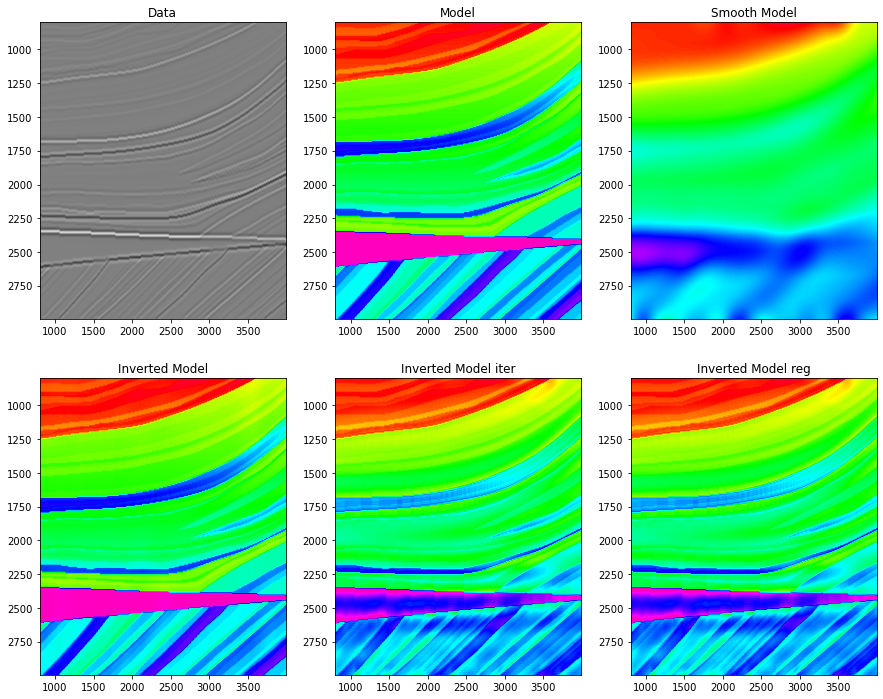

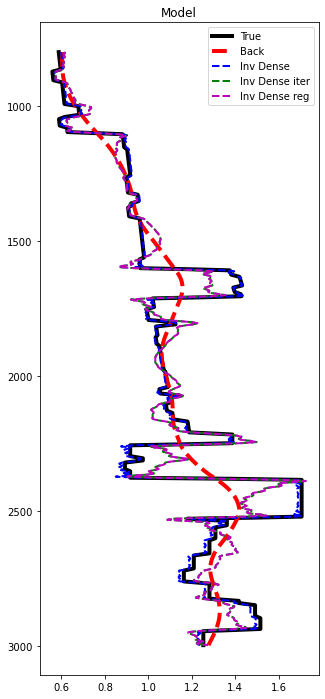

In [23]:
wav_cp = cp.asarray(wav).astype(dtype)

minv_dense, dr_dense = PoststackInversion(d_dense, wav_cp, m0=mback, explicit=True, simultaneous=False, **dict(rcond=1e-5))
minv_dense_iter, dr_dense_iter = PoststackInversion(d_dense, wav_cp, m0=mback, explicit=True, simultaneous=True, 
                                                    **dict(niter=50))
minv_dense_reg, dr_dense_reg = PoststackInversion(d_dense, wav_cp, m0=mback, explicit=True, epsR=np.sqrt(1e-4), 
                                                      **dict(engine='pylops', damp=np.sqrt(1e-4), niter=50))
minv_lop_iter, dr_lop_iter = PoststackInversion(d, wav_cp, m0=mback, explicit=False, 
                                                    **dict(niter=50))
minv_lop_reg, dr_lop_reg = PoststackInversion(d, wav_cp, m0=mback, explicit=False, epsR=np.sqrt(1e-4),
                                              **dict(engine='pylops', damp=np.sqrt(1e-4), niter=50))

print(minv_dense.dtype, minv_dense_iter.dtype, minv_dense_reg.dtype, minv_lop_iter.dtype, minv_lop_reg.dtype)

fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(cp.asnumpy(d), cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(cp.asnumpy(m), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(cp.asnumpy(mback), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(cp.asnumpy(minv_dense), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(cp.asnumpy(minv_dense_iter), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model iter')
axs[1][1].axis('tight');
axs[1][2].imshow(cp.asnumpy(minv_dense_reg), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model reg')
axs[1][2].axis('tight');

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(cp.asnumpy(m)[:,nx//2], z, 'k', lw=4, label='True')
ax.plot(cp.asnumpy(mback)[:,nx//2], z, '--r', lw=4, label='Back')
ax.plot(cp.asnumpy(minv_dense)[:,nx//2], z, '--b', lw=2, label='Inv Dense')
ax.plot(cp.asnumpy(minv_dense_iter)[:,nx//2], z, '--g', lw=2, label='Inv Dense iter')
ax.plot(cp.asnumpy(minv_dense_reg)[:,nx//2], z, '--m', lw=2, label='Inv Dense reg')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

In [24]:
PPop_np = PoststackLinearModelling(wav.astype(dtype), nt0=nz, spatdims=nx, explicit=False)
PPop_dense_np = PoststackLinearModelling(wav.astype(dtype), nt0=nz, spatdims=nx, explicit=True)

In [25]:
%timeit -r 3 -n 3 normal_equations_inversion(PPop_dense, d_r_dense.ravel(), [D2op], epsRs=[np.sqrt(1e-4)], **dict(engine='pylops', niter=100))
%timeit -r 3 -n 3 normal_equations_inversion(PPop, d_r_dense.ravel(), [D2op], epsRs=[np.sqrt(1e-4)], **dict(engine='pylops', niter=100))

d_np = cp.asnumpy(d)
%timeit -r 3 -n 3 normal_equations_inversion(PPop_dense_np, d_np.ravel(), [D2op], epsRs=[np.sqrt(1e-4)], **dict(maxiter=100))
%timeit -r 3 -n 3 normal_equations_inversion(PPop_np, d_np.ravel(), [D2op], epsRs=[np.sqrt(1e-4)], **dict(maxiter=100))

132 ms ± 2.61 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
283 ms ± 653 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
1.17 s ± 24.6 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
2 s ± 41.8 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [26]:
%timeit -n4 -r2 PoststackInversion(d, wav_cp, m0=mback, explicit=False, epsR=np.sqrt(1e-4), **dict(engine='pylops', damp=np.sqrt(1e-4), niter=50, tol=0))

163 ms ± 174 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [27]:
d_np, mback_np = cp.asnumpy(d), cp.asnumpy(mback)
%timeit -n4 -r2 PoststackInversion(d_np, wav, m0=mback_np, explicit=False, epsR=np.sqrt(1e-4), **dict(damp=np.sqrt(1e-4), iter_lim=50))

2.74 s ± 54.7 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)


## 3D Poststack inversion

In [28]:
ny = 30

y = np.arange(ny)
x, z, m = model['x'], model['z'], np.log(model['model'])
ny, nx, nz = len(y), len(x), len(z)

m3d = np.tile(m[:, :, np.newaxis], (1, 1, ny))
mback3d = np.tile(mback[:, :, np.newaxis], (1, 1, ny))

m3d, mback3d = cp.asarray(m3d).astype(dtype), cp.asarray(mback3d).astype(dtype)

In [29]:
# lop
PPop = PoststackLinearModelling(wav_cp, nt0=nz, spatdims=(nx, ny))
dottest(PPop, nz*nx*ny, nz*nx*ny, verb=True, atol=1e-1, backend='cupy')

# dense
PPop_dense = PoststackLinearModelling(wav_cp, nt0=nz, spatdims=(nx, ny), explicit=True)
dottest(PPop, nz*nx*ny, nz*nx*ny, verb=True, atol=1e-1, backend='cupy')

# data
d = (PPop*m3d.flatten()).reshape(nz, nx, ny)
d_dense = (PPop_dense*m3d.flatten()).reshape(nz, nx, ny)

n = cp.random.normal(0, 1e-2, d_dense.shape).astype(dtype)
dn = d + n
dn_dense = d_dense + n

print(d.dtype, d_dense.dtype)

Dot test passed, v^H(Opu)=-2234.19287109375 - u^H(Op^Hv)=-2234.19580078125
Dot test passed, v^H(Opu)=3371.3994140625 - u^H(Op^Hv)=3371.400390625
float32 float32


float32


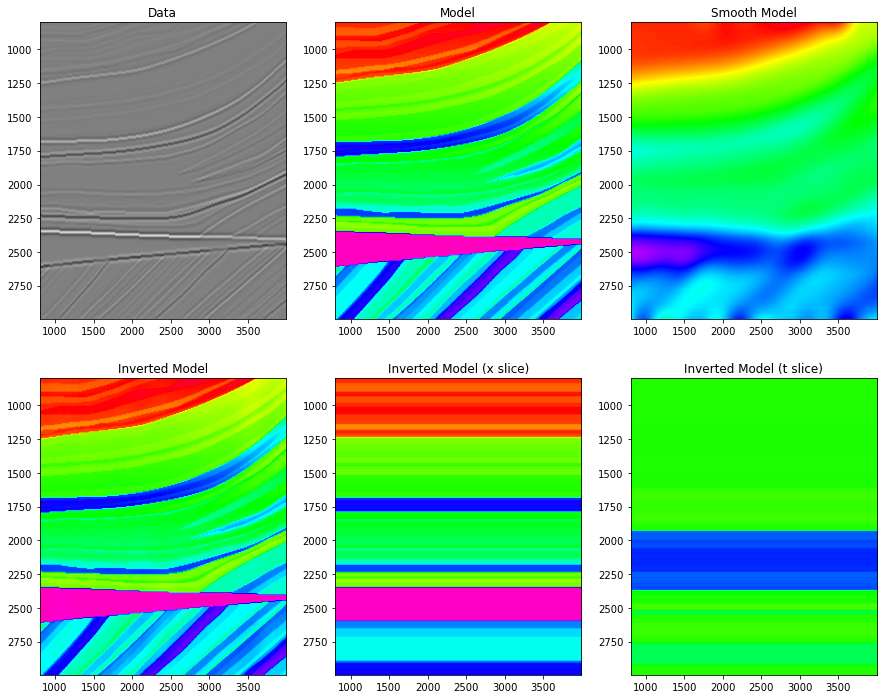

In [30]:
minv_dense_f, dr_dense_f = PoststackInversion(d_dense, wav_cp, m0=mback3d, explicit=True,
                                              simultaneous=False, **dict(rcond=1e-5))
print(minv_dense_f.dtype)

fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(cp.asnumpy(d_dense)[:, :, 5], cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(cp.asnumpy(m3d)[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(cp.asnumpy(mback3d)[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(cp.asnumpy(minv_dense_f)[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(cp.asnumpy(minv_dense_f)[:, 50], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model (x slice)')
axs[1][1].axis('tight')
axs[1][2].imshow(cp.asnumpy(minv_dense_f)[200], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model (t slice)')
axs[1][2].axis('tight');

In [31]:
minv_dense_f, dr_dense_f = PoststackInversion(dn_dense, wav_cp, m0=mback3d, explicit=True, epsI=1e-3, 
                                              simultaneous=False, **dict(rcond=1e-5))

dn_dense.dtype, wav_cp.dtype, mback3d.dtype, minv_dense_f.dtype

(dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'))

float32 float32 float32


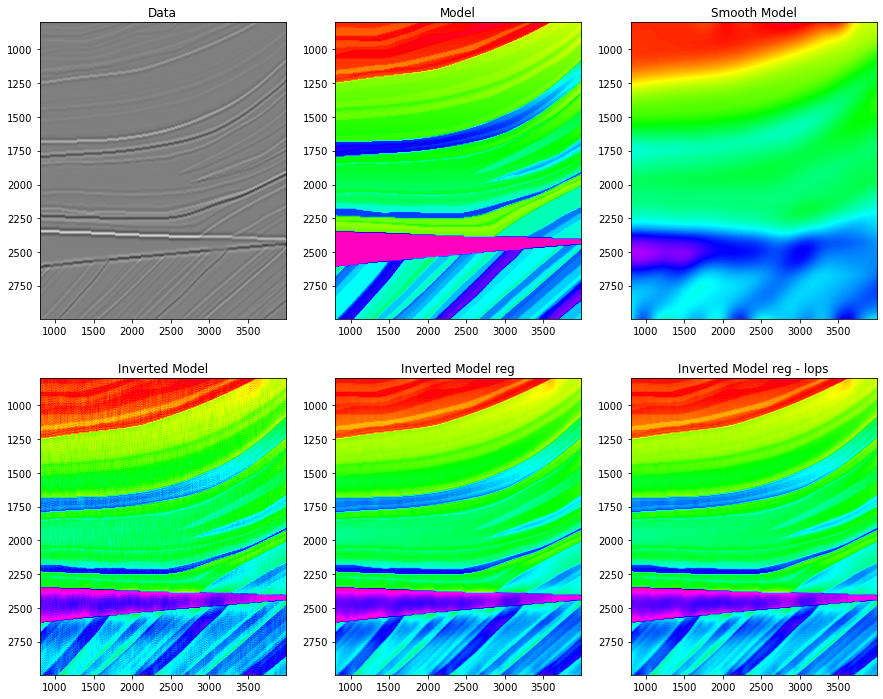

In [32]:
minv_dense_f, dr_dense_f = PoststackInversion(dn_dense, wav_cp, m0=mback3d, explicit=True, epsI=1e-3, 
                                              simultaneous=False, **dict(rcond=1e-5))

minv_dense_reg_f, dr_dense_reg_f = PoststackInversion(dn_dense, wav_cp, m0=minv_dense_f, explicit=True, 
                                                      epsR=np.sqrt(1e2), 
                                                      **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))
minv_lop_reg_f, dr_lop_reg_f = PoststackInversion(dn, wav_cp, m0=minv_dense_f, explicit=False, 
                                                  epsR=np.sqrt(1e2), 
                                                  **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))

print(minv_dense_f.dtype, minv_dense_reg_f.dtype, minv_lop_reg_f.dtype)


fig, axs = plt.subplots(2, 3, figsize=(15,12))
axs[0][0].imshow(cp.asnumpy(dn)[:, :, 5], cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(cp.asnumpy(m3d)[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(cp.asnumpy(mback3d)[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Smooth Model')
axs[0][2].axis('tight')
axs[1][0].imshow(cp.asnumpy(minv_dense_f)[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted Model')
axs[1][0].axis('tight')
axs[1][1].imshow(cp.asnumpy(minv_dense_reg_f)[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted Model reg')
axs[1][1].axis('tight');
axs[1][2].imshow(cp.asnumpy(minv_lop_reg_f)[:, :, 5], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted Model reg - lops')
axs[1][2].axis('tight');

In [33]:
%timeit -n1 -r2 PoststackInversion(dn, wav_cp, m0=minv_dense_f, explicit=False,  epsR=np.sqrt(1e2), **dict(engine='pylops', damp=np.sqrt(1e-2), niter=5))

627 ms ± 15.9 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [34]:
dn_np, minv_dense_np = cp.asnumpy(dn), cp.asnumpy(minv_dense_f)
%timeit -n1 -r2 PoststackInversion(dn_np, wav, m0=minv_dense_np, explicit=False,  epsR=np.sqrt(1e2), **dict(damp=np.sqrt(1e-2), iter_lim=5))

34.9 s ± 1.98 s per loop (mean ± std. dev. of 2 runs, 1 loop each)


## 2D Prestack inversion

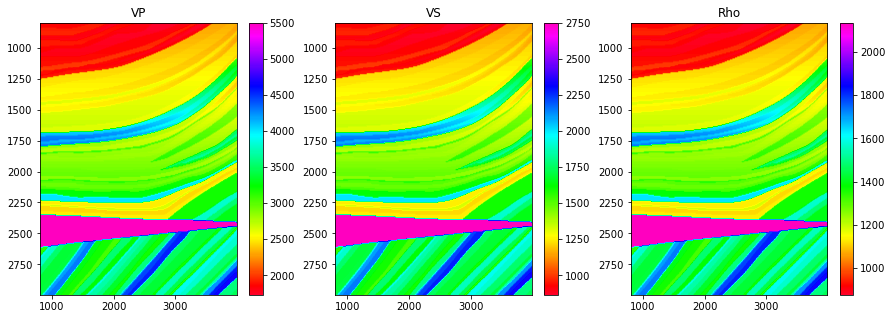

In [35]:
model = np.load(inputfile)
x, z, m = model['x'][::3], model['z'], 1000*model['model'][:, ::3]
nx, nz = len(x), len(z)

mvp = m.copy()
mvs = m/2
mrho = m/3+300

fig, axs = plt.subplots(1, 3, figsize=(15,5))
im=axs[0].imshow(mvp, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
              vmin=mvp.min(), vmax=mvp.max())
axs[0].set_title('VP')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(mvs, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=mvs.min(), vmax=mvs.max())
axs[1].set_title('VS')
plt.colorbar(im, ax=axs[1])
axs[1].axis('tight')
im=axs[2].imshow(mrho, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=mrho.min(), vmax=mrho.max())
axs[2].set_title('Rho')
axs[2].axis('tight');
plt.colorbar(im, ax=axs[2]);

In [36]:
m = np.log(np.stack((mvp, mvs, mrho),axis=1))
m = cp.asarray(m).astype(np.float32)

theta = cp.linspace(thetamin, thetamax, ntheta).astype(np.float32)

# lop (constant vsvp)
PPop = PrestackLinearModelling(wav_cp.astype(np.float32), theta, vsvp=vsvp, nt0=nz, 
                               spatdims=(nx,), linearization='akirich')
dottest(PPop, nz*ntheta*nx, nz*3*nx, atol=1e-2, verb=True, backend='cupy')

# dense (constant vsvp)
PPop_dense = PrestackLinearModelling(wav_cp.astype(np.float32), theta, vsvp=vsvp, nt0=nz, 
                                     spatdims=(nx,), linearization='akirich', explicit=True)
dottest(PPop_dense, nz*ntheta*nx, nz*3*nx, atol=1e-2, verb=True, backend='cupy')

# lop
dPP = PPop * m.flatten()
dPP = dPP.reshape(nz,ntheta,nx)

# dense
dPP_dense = PPop_dense*m.swapaxes(0,1).flatten()
dPP_dense = dPP_dense.reshape(ntheta,nz,nx).swapaxes(0,1)
dPPn_dense = dPP_dense + cp.random.normal(0, 5e-2, dPP_dense.shape).astype(np.float32)

print(dPP.dtype, dPP_dense.dtype)

Dot test passed, v^H(Opu)=1663.968017578125 - u^H(Op^Hv)=1663.966796875
Dot test passed, v^H(Opu)=-2123.78759765625 - u^H(Op^Hv)=-2123.78955078125
float32 float32


In [37]:
madj_dense = PPop_dense.H*(dPP_dense.swapaxes(0,1).flatten())
madj = PPop.H*dPP.flatten()

madj_dense = madj_dense.reshape(3,nz,nx).swapaxes(0,1)
madj = madj.reshape(nz,3,nx)

print((dPP-dPP_dense).max())
print((madj-madj_dense).max())

1.3783574e-06
1.1444092e-05


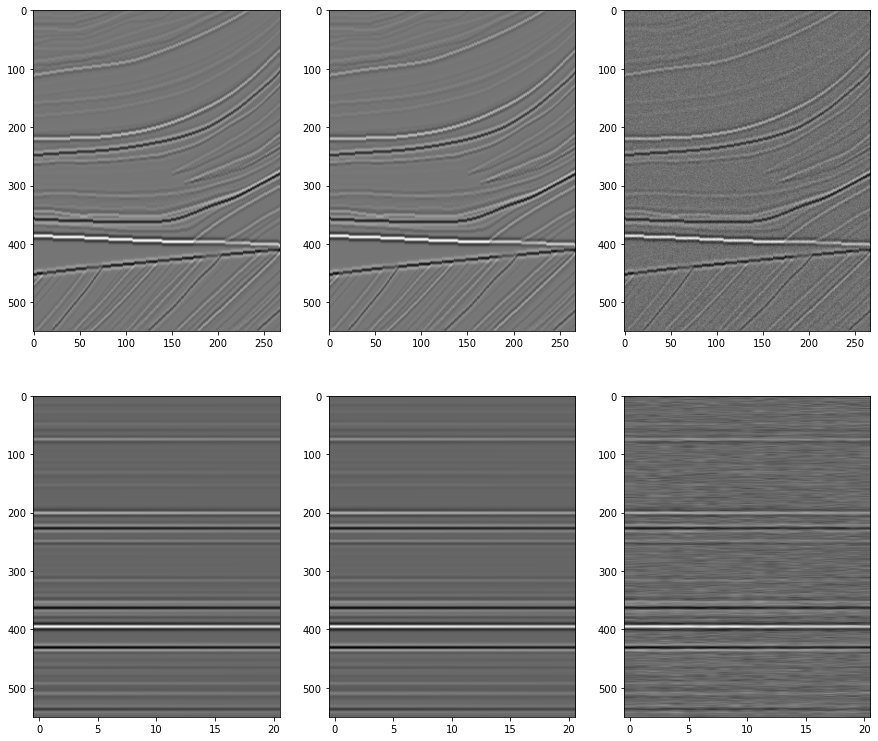

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(15,13))
axs[0][0].imshow(cp.asnumpy(dPP)[:,0,:], cmap='gray')
axs[0][0].axis('tight')
axs[0][1].imshow(cp.asnumpy(dPP_dense)[:,0,:], cmap='gray')
axs[0][1].axis('tight')
axs[0][2].imshow(cp.asnumpy(dPPn_dense)[:,0,:], cmap='gray')
axs[0][2].axis('tight')
axs[1][0].imshow(cp.asnumpy(dPP)[:,:,nx//2], cmap='gray')
axs[1][0].axis('tight')
axs[1][1].imshow(cp.asnumpy(dPP_dense)[:,:,nx//2], cmap='gray')
axs[1][1].axis('tight')
axs[1][2].imshow(cp.asnumpy(dPPn_dense)[:,:,nx//2], cmap='gray')
axs[1][2].axis('tight');

In [39]:
def plotinversion(m, mback, minv, params = ['VP', 'VS', 'Rho'], title=None):
    fig, axs = plt.subplots(3, 3, figsize=(15,12))
    fig.suptitle(title, y=0.99)
    for ip, param in enumerate(params):
        im=axs[0][ip].imshow(m[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                  vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[0][ip].set_title(param+' - true')
        axs[0][ip].axis('tight')
        plt.colorbar(im, ax=axs[0][ip])

        im=axs[1][ip].imshow(mback[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                             vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[1][ip].set_title(param+' - back')
        axs[1][ip].axis('tight')
        plt.colorbar(im, ax=axs[1][ip])
        im=axs[2][ip].imshow(minv[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                             vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[2][ip].set_title(param+' - inv')
        axs[2][ip].axis('tight')
        plt.colorbar(im, ax=axs[2][ip])

float32


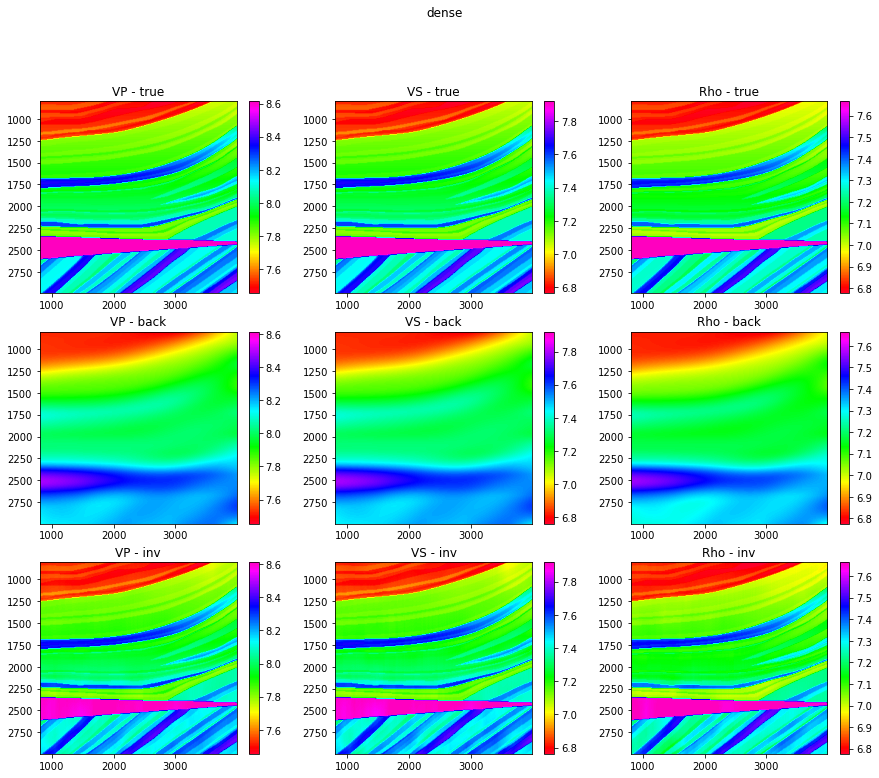

In [40]:
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, cp.asnumpy(m), axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=2)

minv_dense, dPP_dense_res = \
    PrestackInversion(dPP_dense, cp.asarray(theta), wav_cp, m0=cp.asarray(mback).astype(dtype), linearization='akirich',
                      explicit=True, simultaneous=False, dottest=False, 
                      returnres=True, **dict(rcond=1e-5))
print(minv_dense.dtype)

plotinversion(cp.asnumpy(m), mback, cp.asnumpy(minv_dense), params = ['VP', 'VS', 'Rho'], title='dense')

In [45]:
# cupy explicit
%timeit -n1 -r3 PrestackInversion(dPP_dense, cp.asarray(theta), wav_cp, m0=cp.asarray(mback).astype(dtype), linearization='akirich', explicit=True, simultaneous=False)

537 ms ± 24.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [46]:
# numpy explicit
dPP_dense_np, mback_np = cp.asnumpy(dPP_dense), cp.asnumpy(mback) 
theta_np, wav_np = cp.asnumpy(theta), cp.asnumpy(wav)
%timeit -n1 -r3 PrestackInversion(dPP_dense_np, theta_np, wav_np, m0=mback_np, linearization='akirich', explicit=True, simultaneous=False)

1.94 s ± 230 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [47]:
# cupyu iterative
%timeit -n1 -r3 PrestackInversion(dPP_dense, cp.asarray(theta), wav_cp, m0=cp.asarray(mback).astype(dtype), linearization='akirich', explicit=False, simultaneous=False, **dict(niter=4))

42.7 ms ± 1.67 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [48]:
# numpy iterative
%timeit -n1 -r3 PrestackInversion(dPP_dense_np, theta_np, wav_np, m0=mback_np, linearization='akirich', explicit=False, simultaneous=False, **dict(iter_lim=4))

1.24 s ± 2.69 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
